In [1]:
import ml_collections
import copy
import numpy as np
import matplotlib.pyplot as plt
import ml_collections
import yaml
from tqdm import tqdm
import os
import torch
import torch.nn as nn
from os import path as pt
import pickle
from src.evaluations.evaluations import fake_loader, full_evaluation
from src.utils import get_experiment_dir, set_seed, init_weights, save_obj
from torch.utils.data import DataLoader, TensorDataset
from src.baselines.models import GENERATORS, get_trainer
from src.baselines.base import BaseTrainer

## Load time series data

In [2]:
with open("./data/ref_data.pkl", "rb") as f:
    loaded_array = pickle.load(f)
data = torch.tensor(loaded_array)
print(data.shape)
print(data[:10,:,1 ])

torch.Size([20000, 20, 4])
tensor([[0.4000, 0.4139, 0.4040, 0.4107, 0.3902, 0.3755, 0.3846, 0.3800, 0.3792,
         0.3868, 0.3936, 0.3998, 0.3709, 0.3496, 0.3475, 0.3333, 0.3229, 0.3108,
         0.3133, 0.3219],
        [0.4000, 0.4125, 0.4244, 0.4446, 0.4638, 0.4699, 0.4735, 0.5012, 0.4902,
         0.5142, 0.5320, 0.4804, 0.4681, 0.4269, 0.4294, 0.4144, 0.3832, 0.3822,
         0.3737, 0.3660],
        [0.1000, 0.0797, 0.0882, 0.1080, 0.0928, 0.0869, 0.0773, 0.1217, 0.1032,
         0.0870, 0.0729, 0.0798, 0.0689, 0.0891, 0.0793, 0.0800, 0.0903, 0.0796,
         0.1008, 0.1039],
        [0.4000, 0.3905, 0.3609, 0.3625, 0.3482, 0.3418, 0.3341, 0.3247, 0.3342,
         0.3401, 0.3405, 0.3451, 0.3347, 0.3332, 0.3245, 0.3401, 0.3369, 0.3316,
         0.3017, 0.2942],
        [0.1000, 0.1181, 0.1174, 0.0852, 0.0841, 0.0785, 0.0880, 0.0887, 0.0847,
         0.0892, 0.1157, 0.1064, 0.1028, 0.1061, 0.1008, 0.0859, 0.1107, 0.1095,
         0.1130, 0.1088],
        [0.1000, 0.1078, 0.1019, 

# Plot samples of real time series

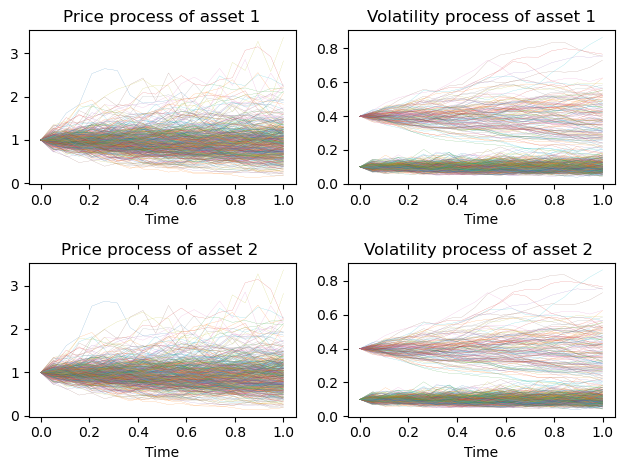

In [4]:
N = 500
fig, axs = plt.subplots(2, 2)
y_label = ['price_asset_1', 'volatility_asset_1', 'price_asset_2', 'volatility_asset_2']
time = np.linspace(0, 1, 20)
for i in range(N):
    axs[0,0].plot(time, data[i,:,0], linewidth = 0.1)
# plt.legend()
axs[0,0].set_title("Price process of asset 1")
axs[0,0].set_xlabel("Time")
#plt.show()
for i in range(N):
    axs[0, 1].plot(time, data[i,:,1], linewidth = 0.1)
# plt.legend()
axs[0, 1].set_title("Volatility process of asset 1")
axs[0, 1].set_xlabel("Time")

for i in range(N):
    axs[1,0].plot(time, data[i,:,0], linewidth = 0.1)
# plt.legend()
axs[1,0].set_title("Price process of asset 2 ")
axs[1,0].set_xlabel("Time")

for i in range(N):
    axs[1,1].plot(time, data[i,:,1], linewidth = 0.1)
#
axs[1,1].set_title("Volatility process of asset 2 ")
axs[1,1].set_xlabel("Time")
plt.tight_layout()
plt.show()

## Regime-switching pattern

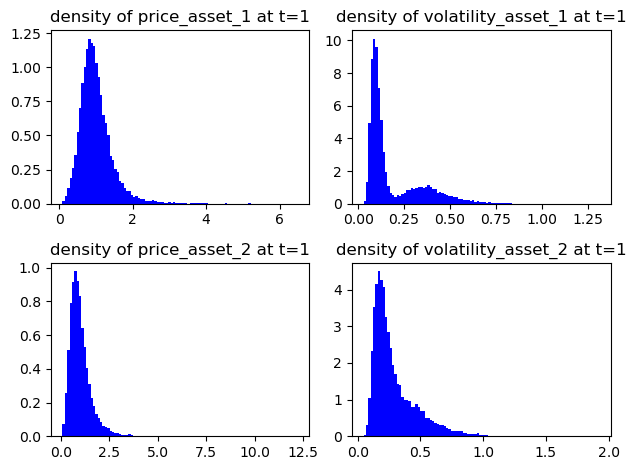

In [4]:
fig, axs = plt.subplots(2, 2)
y_label1 = ['density of price_asset_1 at t=1', 'density of volatility_asset_1 at t=1']

for i in range(2):
    axs[0, i].hist(data[:,-1, i].cpu(), bins = 100, color = 'blue', density = True)
    axs[0, i].set_title(y_label1[i])
#     axs[0, i].set_xlabel('time')

y_label2 = ['density of price_asset_2 at t=1', 'density of volatility_asset_2 at t=1']

for i in range(2):
    axs[1,i].hist(data[:,-1, 2+i].cpu(), bins = 100, color = 'blue', density = True)
    axs[1,i].set_title(y_label2[i])
fig.tight_layout()
plt.show()

# Generative models for time series generation

In [5]:
# Load configuration dict
config_dir = 'configs/config.yaml'
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))
    
set_seed(config.seed)

if (config.device ==
        "cuda" and torch.cuda.is_available()):
    config.update({"device": "cuda:0"}, allow_val_change=True)
else:
    config.update({"device": "cpu"}, allow_val_change=True)

# Load the dataset
training_set = TensorDataset(data.to(config.device).to(torch.float))

train_dl = DataLoader(
    training_set,
    batch_size=config.batch_size,
    shuffle=True
)

config.input_dim = training_set[0][0].shape[-1]

## Sample model based on LSTM

In [6]:
# Sample model based on LSTM
class GeneratorBase(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GeneratorBase, self).__init__()
        """ Generator base class. All generators should be children of this class. """
        self.input_dim = input_dim
        self.output_dim = output_dim

    # @abstractmethod
    def forward_(self, batch_size: int, n_lags: int, device: str):
        """ Implement here generation scheme. """
        # ...
        pass

    def forward(self, batch_size: int, n_lags: int, device: str):
        x = self.forward_(batch_size, n_lags, device)
        x = self.pipeline.inverse_transform(x)
        return x


class LSTMGenerator(GeneratorBase):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int, n_layers: int, init_fixed: bool = True):
        super(LSTMGenerator, self).__init__(input_dim, output_dim)
        # LSTM
        self.rnn = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                           num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim, bias=True)
        self.linear.apply(init_weights)
        # neural network to initialise h0 from the LSTM
        # we put a tanh at the end because we are initialising h0 from the LSTM, that needs to take values between [-1,1]

        self.init_fixed = init_fixed

    def forward(self, batch_size: int, n_lags: int, device: str, condition=None, z=None) -> torch.Tensor:
        if condition is not None:
            z = (0.1 * torch.randn(batch_size, n_lags,
                                   self.input_dim-condition.shape[-1])).to(device)  # cumsum(1)
            z[:, 0, :] *= 0  # first point is fixed
            z = z.cumsum(1)
            z = torch.cat([z, condition], dim=2)
        else:
            if z is None:
                z = (0.1 * torch.randn(batch_size, n_lags,
                                       self.input_dim)).to(device)  # cumsum(1)
            else:
                pass
            if self.init_fixed:
                h0 = torch.zeros(self.rnn.num_layers, batch_size,
                                 self.rnn.hidden_size).to(device)
            else:
                h0 = torch.randn(self.rnn.num_layers, batch_size, self.rnn.hidden_size).to(
                    device).requires_grad_()
            z[:, 0, :] *= 0
            z = z.cumsum(1)
        c0 = torch.zeros_like(h0)
        h1, _ = self.rnn(z, (h0, c0))
        x = self.linear(h1)

        assert x.shape[1] == n_lags
        return x
    
class LSTMDiscriminator(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, n_layers: int, out_dim=1, return_seq=False):
        super(LSTMDiscriminator, self).__init__()
        self.input_dim = input_dim
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, out_dim)
        self.return_seq = return_seq

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.return_seq:
            h = self.lstm(x)[0]
        else:
            h = self.lstm(x)[0][:, -1:]
        x = self.linear(h)
        return x    

## Define the training algorithm

In [7]:
class RCGANTrainer(BaseTrainer):
    def __init__(self, D, G, train_dl, config,
                 **kwargs):
        super(RCGANTrainer, self).__init__(
            G=G,
            G_optimizer=torch.optim.Adam(
                G.parameters(), lr=config.lr_G, betas=(0, 0.9)),
            **kwargs
        )

        self.config = config
        self.D_steps_per_G_step = config.D_steps_per_G_step
        self.D = D
        self.D_optimizer = torch.optim.Adam(
            D.parameters(), lr=config.lr_D, betas=(0, 0.9))  # Using TTUR

        self.train_dl = train_dl
        self.reg_param = 0
        self.losses_history

    def fit(self, device):
        self.G.to(device)
        self.D.to(device)

        for i in tqdm(range(self.n_gradient_steps)):
            self.step(device, i)

    def step(self, device, step):
        for i in range(self.D_steps_per_G_step):
            # generate x_fake
            condition = None
            x_real_batch = next(iter(self.train_dl))[0].to(device)
            with torch.no_grad():
                x_fake = self.G(batch_size=self.batch_size,
                                n_lags=self.config.n_lags, condition=condition, device=device)

            D_loss_real, D_loss_fake = self.D_trainstep(
                x_fake, x_real_batch)
            if i == 0:
                self.losses_history['D_loss_fake'].append(D_loss_fake)
                self.losses_history['D_loss_real'].append(D_loss_real)
                self.losses_history['D_loss'].append(D_loss_fake + D_loss_real)
        G_loss = self.G_trainstep(x_real_batch, device, step)

    def G_trainstep(self, x_real, device, step):
        condition = None
        x_fake = self.G(batch_size=self.batch_size,
                        n_lags=self.config.n_lags, condition=condition, device=device)
        self.toggle_grad(self.G, True)
        self.G.train()
        self.G_optimizer.zero_grad()
        d_fake = self.D(x_fake)
        self.D.train()
        G_loss = self.compute_loss(d_fake, 1.)
        G_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            self.G.parameters(), 10)
        self.losses_history['G_loss'].append(G_loss)
        self.G_optimizer.step()

        return G_loss.item()

    def D_trainstep(self, x_fake, x_real):
        self.toggle_grad(self.D, True)
        self.D.train()
        self.D_optimizer.zero_grad()

        # On real data
        x_real.requires_grad_()
        d_real = self.D(x_real)
        dloss_real = self.compute_loss(d_real, 1.)

        # On fake data
        x_fake.requires_grad_()
        d_fake = self.D(x_fake)
        dloss_fake = self.compute_loss(d_fake, 0.)

        # Compute regularizer on fake / real
        dloss = dloss_fake + dloss_real

        dloss.backward()
        torch.nn.utils.clip_grad_norm_(
            self.D.parameters(), 10)
        # Step discriminator params
        self.D_optimizer.step()

        # Toggle gradient to False
        self.toggle_grad(self.D, False)

        return dloss_real.item(), dloss_fake.item()

    def compute_loss(self, d_out, target):
        targets = d_out.new_full(size=d_out.size(), fill_value=target)
        loss = torch.nn.BCELoss()(torch.nn.Sigmoid()(d_out), targets)
        return loss

    def save_model_dict(self):
        save_obj(self.G.state_dict(), pt.join(
            self.config.exp_dir, 'generator_state_dict.pt'))

## Initialize the generator, discriminator and the trainer

In [8]:
D_out_dim = 1
return_seq = True

generator = LSTMGenerator(
    input_dim=config.G_input_dim, hidden_dim=config.G_hidden_dim, output_dim=config.input_dim,
    n_layers=config.G_num_layers, init_fixed=config.init_fixed)
discriminator = LSTMDiscriminator(
    input_dim=config.input_dim, hidden_dim=config.D_hidden_dim, out_dim=D_out_dim, n_layers=config.D_num_layers,
    return_seq=return_seq)
    # print('GENERATOR:', generator)
    # print('DISCRIMINATOR:', discriminator)

trainer = RCGANTrainer(G=generator, D=discriminator,
                    train_dl=train_dl, batch_size=config.batch_size, n_gradient_steps=config.steps,
                    config=config)

# Create model directory and instantiate config.path
get_experiment_dir(config)

WARNING! The model exists in directory and will be overwritten


## Model training

In [9]:
# Model training
trainer.fit(config.device)
trainer.save_model_dict()

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 13.58it/s]


## Synthetic data generation

In [12]:
# Generate fake data

# Load validation dataset
with open("./data/val_data.pkl", "rb") as f:
    validation_set = pickle.load(f)
    
generator = LSTMGenerator(
    input_dim=config.G_input_dim, hidden_dim=config.G_hidden_dim, output_dim=config.input_dim, n_layers=config.G_num_layers, init_fixed=config.init_fixed)
generator.load_state_dict(torch.load(pt.join(
    config.exp_dir, 'generator_state_dict.pt')))

generator.eval()
with torch.no_grad():
    fake_dataset = generator(len(validation_set), config.n_lags,
                                  device='cpu').numpy()
    
with open("./data/fake_data.pkl", "wb") as f:
    pickle.dump(fake_dataset, f)

## Model evaluation

In [13]:
# Load validation dataset
with open("./data/val_data.pkl", "rb") as f:
    validation_set = pickle.load(f)
    
# Load fake dataset
with open("./data/fake_data.pkl", "rb") as f:
    fake_dataset = pickle.load(f)

res_dict = full_evaluation(validation_set, fake_dataset, config)
for k, v in res_dict.items():
    print(k, v)

Accuracy of the network on the 800 test samples: 99.875
predictor(
  (rnn): LSTM(4, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=8, bias=True)
)
Predictive Score 0.32127724528312684
Discriminative Score 0.49875
Marginal Score 1.1916721
Correlation Score 2.9889538
Auto-correlation Score 0.6517665
Covariance Score 0.025414629
